<h1> Semi supervised by learning rotation </h1>
<h2>Data</h2>

We will be using a dataset that can be obtained directly from the torchvision package. There are 10 classes and we will be training a CNN for the image classification task. We have training, validation and test sets that are labelled with the class, and a large unlabeled set.

We will simulating a low training data scenario by only sampling a small percentage of the labelled data (10%) as training data. The remaining examples will be used as the validation set.

To get the labelled data, change the dataset_dir to something suitable for your machine, and execute the following (you will then probably want to wrap the dataset objects in a PyTorch DataLoader):

In [48]:
import torch
from torchvision.datasets import STL10 as STL10
import torchvision.transforms as transforms
from torch.utils.data import random_split
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision

import multiprocessing
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import clear_output
import os
import time
import copy

# For rotation
from PIL import Image
from typing import Any, Callable, Optional, Tuple

####### CHANGE TO APPROPRIATE DIRECTORY TO STORE DATASET
dataset_dir = os.getcwd()+"/CNN-VAE/data"
#For MonARCH
# dataset_dir = "/mnt/lustre/projects/ds19/SHARED"

#All images are 3x96x96
image_size = 96
#Example batch size
batch_size = 32
# Number of resnet classes out
shuffleNet_out_classes = 10
# Number of classes for classification (modifed for the rotations 0, 90, 180 and 270)
shuffle_out_classes = 24

save_dir = 'Models'
#Create the save directory if it does note exist
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
    
# Hardware acceleration
GPU_indx = 0
device = torch.device(GPU_indx if torch.cuda.is_available() else 'cpu')

### Create special dataloader for unlabeled data 
images will be rotated and the label will be set as 0, 1, 2 or 3 corrolating to 0, 90, 180 and 270 degrees rotation

In [49]:
# Python function to print permutations of a given list 
def permutation(lst): 
  
    # If lst is empty then there are no permutations 
    if len(lst) == 0: 
        return [] 
  
    # If there is only one element in lst then, only 
    # one permuatation is possible 
    if len(lst) == 1: 
        return [lst] 
  
    # Find the permutations for lst if there are 
    # more than 1 characters 
  
    l = [] # empty list that will store current permutation 
  
    # Iterate the input(lst) and calculate the permutation 
    for i in range(len(lst)): 
       m = lst[i] 
  
       # Extract lst[i] or m from the list.  remLst is 
       # remaining list 
       remLst = lst[:i] + lst[i+1:] 
  
       # Generating all permutations where m is first 
       # element 
       for p in permutation(remLst): 
           l.append([m] + p) 
    return l

def permSet(indx):
    if indx == 0:
        return [0,1,2,3]
    elif indx == 1:
        return [0,1,3,2]
    elif indx == 2:
        return [0,2,1,3]
    elif indx == 3:
        return [0,2,3,1]
    elif indx == 4:
        return [0,3,1,2]
    elif indx == 5:
        return [0,3,2,1]
    elif indx == 6:
        return [1,0,2,3]
    elif indx == 7:
        return [1,0,3,2]
    elif indx == 8:
        return [1,2,0,3]
    elif indx == 9:
        return [1,2,3,0]
    elif indx == 10:
        return [1,3,0,2]
    elif indx == 11:
        return [1,3,2,0]
    elif indx == 12:
        return [2,0,1,3]
    elif indx == 13:
        return [2,0,3,1]
    elif indx == 14:
        return [2,1,0,3]
    elif indx == 15:
        return [2,1,3,0]
    elif indx == 16:
        return [2,3,0,1]
    elif indx == 17:
        return [2,3,1,0]
    elif indx == 18:
        return [3,0,1,2]
    elif indx == 19:
        return [3,0,2,1]
    elif indx == 20:
        return [3,1,0,2]
    elif indx == 21:
        return [3,1,2,0]
    elif indx == 22:
        return [3,2,0,1]
    elif indx == 23:
        return [3,2,1,0]

def shuffle(img, perm):
    imgArr = []
    
    imgArr.append(img[  0:48, 0:48 , :])
    imgArr.append(img[  0:48, 48:96, :])
    imgArr.append(img[ 48:96, 0:48 , :])
    imgArr.append(img[ 48:96, 48:96, :])

    order = permSet(perm)

    #print(imgArr[0].shape)
    #print(imgArr[1].shape)
    #print(imgArr[2].shape)
    #print(imgArr[3].shape)

    topRow = np.concatenate((imgArr[order[0]], imgArr[order[1]]), axis=1)
    bottomRow = np.concatenate((imgArr[order[2]], imgArr[order[3]]), axis=1)

    #print(topRow.shape)
    #print(bottomRow.shape)

    output = np.concatenate((topRow, bottomRow), axis=0)

    #print(output.shape)

    return output

"Class roatates unlabled images and labels them with there rotation"
class shuffleSTL10 (STL10):
    def __init__(
            self,
            root: str,
            split: str = "unlabeled",
            folds: Optional[int] = None,
            transform: Optional[Callable] = None,
            target_transform: Optional[Callable] = None,
            download: bool = False) -> None:
        super(shuffleSTL10, self).__init__(root, split, folds, transform, target_transform, download)
    
    def __getitem__(self, index: int) -> Tuple[Any, Any]:

        # Currently no clue what this line does or if its needed
        target: Optional[int]
        
        img, target = self.data[index], None

        # Perform shuffling
        target = np.random.random_integers(0, 23).item()
        img = shuffle(np.transpose(img, (1, 2, 0)), target)

        # doing this so that it is consistent with all other datasets
        # to return a PIL Image
        img = Image.fromarray(img)

        if self.transform is not None:
            img = self.transform(img)

        if self.target_transform is not None:
            target = self.target_transform(target)

        return img, target


<h3>Create the appropriate transforms</h3>

In [50]:
#Perform random crops and mirroring for data augmentation
transform_train = transforms.Compose([
    transforms.RandomCrop(image_size, padding=4),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

# Removed random h-flip as it might not make sense when trying to learn rotations
transform_unlabelled = transforms.Compose([
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

#No random 
transform_test = transforms.Compose([
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])


<h3>Create training and validation split</h3>

In [53]:
#Load train and validation sets
trainval_set = STL10(dataset_dir, split='train', transform=transform_train, download=True)

#Use 10% of data for training - simulating low data scenario
num_train = int(len(trainval_set)*0.1)

#Split data into train/val sets
torch.manual_seed(0) #Set torch's random seed so that random split of data is reproducible
train_set, val_set = random_split(trainval_set, [num_train, len(trainval_set)-num_train])

#Load test set
test_set = STL10(dataset_dir, split='test', transform=transform_test, download=True)

Files already downloaded and verified
Files already downloaded and verified


<h3>Get the unlabelled data</h3>

In [51]:
unlabelled_set = shuffleSTL10(dataset_dir, split='unlabeled', transform=transform_unlabelled, download=True)

Files already downloaded and verified


<h3>Create the four dataloaders</h3>

In [54]:
train_loader = DataLoader(train_set, shuffle=True, batch_size=batch_size)
unlabelled_loader = DataLoader(unlabelled_set, shuffle=True, batch_size=batch_size)

valid_loader = DataLoader(val_set, batch_size=batch_size)
test_loader  = DataLoader(test_set, batch_size=batch_size)

Test the images

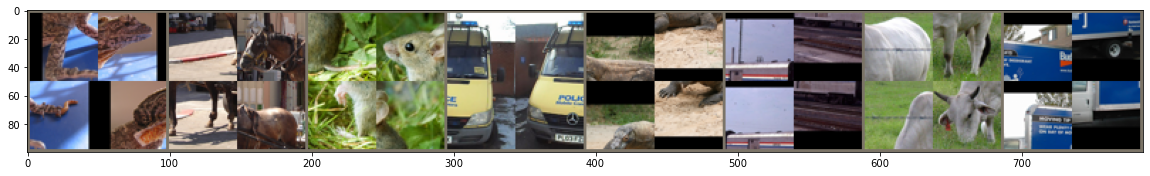

In [55]:
def normalize_img(img):
    mins = img.min(0, keepdims = True).min(1, keepdims = True)
    maxs = img.max(0, keepdims = True).max(1, keepdims = True)
    return (img - mins)/(maxs - mins)


plt.figure(figsize = (20,10))
images, labels = next(iter(unlabelled_loader))
out = torchvision.utils.make_grid(images[0:8])
plt.imshow(normalize_img(out.numpy().transpose((1, 2, 0))))

### Generic train and eval/test

In [56]:
# Code is modifed from the recomened training method https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html refured to from the project discription

def train_model(model, dataloaders, criterion, optimizer, save_path, num_epochs=25, is_test = False, is_unlabelled = False):
    """
    Trains the model

    Parameters
    ----------
    model : pytorch net
    dataloaders : [DataLoader]
        list of dataloaders. Train the val loader
    criterion : torch.nn
    optimizer : torch.optim
    save_path : str
        save path for the model
    num_epochs : int, optional
    is_test : bool, optional
        if True then give dataloaders a list with a single Dataloader and will run it with a validation method
    is_unlabelled : bool, optional
        if True pass give dataloaders a list with a single Dataloader and will run it with a train method

    Returns
    -------
    best_acc
        best validation accuracy
    best_epoch
        epoch at best validation accuracy
    train_acc_history
    train_loss_history
    val_acc_history
    val_loss_history
    """
    start = time.time()

    # Phases in same order as dataloaders list -> [train_loader, val_loader]
    phases = ['train', 'val']

    """Use a method like this to add custom learning methods if needed"""
    # If round is for testing only do 1 epoch and run it in validation 
    if is_test:
        num_epochs = 1
        phases = ['test']

    """Example added dataset, dataloaders->[unlabelled_loader]"""
    forceSave = False
    if is_unlabelled:
        phases = ['train']
        forceSave = True

    # Keep track of stats
    val_acc_history = []
    val_loss_history = []
    train_acc_history = []
    train_loss_history = []

    best_acc = 0.0
    best_epoch = 0

    for epoch in range(num_epochs):
        print('Epoch: [%2d/%d]' %(epoch+1, num_epochs), end='')

        # Each epoch has a training and validation phase
        for ip, phase in enumerate(phases):
            if phase == 'train':
                model.train() 
            else:
                model.eval()   

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[ip]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            # Epoch loss and epoch acc as %
            epoch_loss = running_loss / len(dataloaders[ip].dataset)
            epoch_acc = (running_corrects.double() / len(dataloaders[ip].dataset))*100

            print(' [ phase: %s | Loss: %5.4f | Acc: %5.2f%% ]' %(phase, epoch_loss, epoch_acc), end='')

            # Save the model
            if (phase == 'val' and epoch_acc > best_acc) or forceSave:
                torch.save(model.state_dict(), save_path)

            # Get the best acc and epoch
            if (phase == 'val' or phase == 'test') and epoch_acc > best_acc:
                best_epoch = epoch
                best_acc = epoch_acc

            # Log epoch data
            if phase == 'train':
                train_acc_history.append(epoch_acc)
                train_loss_history.append(epoch_loss)

            # Fill val logging with test data if applicable
            if phase == 'val' or phase == 'test':
                val_acc_history.append(epoch_acc)
                val_loss_history.append(epoch_loss)

        # Seperate lines
        print()

    time_elapsed = time.time() - start
    print('Best val Acc: %.4f%% @ epoch %d' %(best_acc, best_epoch+1))
    print('Elapsed time: %.0f:%.0f' %(time_elapsed//60, time_elapsed%60))
    print()

    return best_acc, best_epoch, train_acc_history, train_loss_history, val_acc_history, val_loss_history

## Network

Let's use a ResNet18 architecture for our CNN...

In [57]:
# Create resnet and change to output 109 different classes 
net = torchvision.models.resnet18(pretrained=False).to(device)
net_fc_in = net.fc.in_features
net.fc = nn.Linear(net_fc_in, shuffle_out_classes).to(device)

In [58]:
### Hyper paramaters
# Lower number of epochs as this type of learning is really slow
num_epochs = 20
lr=1e-4
optimizer =  torch.optim.Adam(net.parameters(), lr)
loss_func = nn.CrossEntropyLoss()

In [59]:
# Save model 
model_name = 'learningShuffle'
#Create Save Path from save_dir and model_name, we will save and load our checkpoint here
save_path = os.path.join(save_dir, model_name + ".pt")

# Learn the Shuffle

In [60]:
# This takes about 44 minutes on a high end gpu for 20 epochs
best_acc, best_epoch, train_acc_history, train_loss_history, _, _ = train_model(net, [unlabelled_loader], loss_func, optimizer, save_path, num_epochs=num_epochs, is_unlabelled=True)

Epoch: [ 1/20] [ phase: train | Loss: 1.2914 | Acc: 57.19% ]
Epoch: [ 2/20] [ phase: train | Loss: 0.6633 | Acc: 77.38% ]
Epoch: [ 3/20] [ phase: train | Loss: 0.5140 | Acc: 82.23% ]
Epoch: [ 4/20] [ phase: train | Loss: 0.3928 | Acc: 86.41% ]
Epoch: [ 5/20] [ phase: train | Loss: 0.3048 | Acc: 89.48% ]
Epoch: [ 6/20] [ phase: train | Loss: 0.2541 | Acc: 91.18% ]
Epoch: [ 7/20] [ phase: train | Loss: 0.2172 | Acc: 92.36% ]
Epoch: [ 8/20] [ phase: train | Loss: 0.1833 | Acc: 93.57% ]
Epoch: [ 9/20] [ phase: train | Loss: 0.1637 | Acc: 94.30% ]
Epoch: [10/20] [ phase: train | Loss: 0.1415 | Acc: 95.00% ]
Epoch: [11/20] [ phase: train | Loss: 0.1293 | Acc: 95.47% ]
Epoch: [12/20] [ phase: train | Loss: 0.1163 | Acc: 95.93% ]
Epoch: [13/20] [ phase: train | Loss: 0.1046 | Acc: 96.31% ]
Epoch: [14/20] [ phase: train | Loss: 0.0990 | Acc: 96.54% ]
Epoch: [15/20] [ phase: train | Loss: 0.0888 | Acc: 96.89% ]
Epoch: [16/20] [ phase: train | Loss: 0.0844 | Acc: 97.04% ]
Epoch: [17/20] [ phase: 

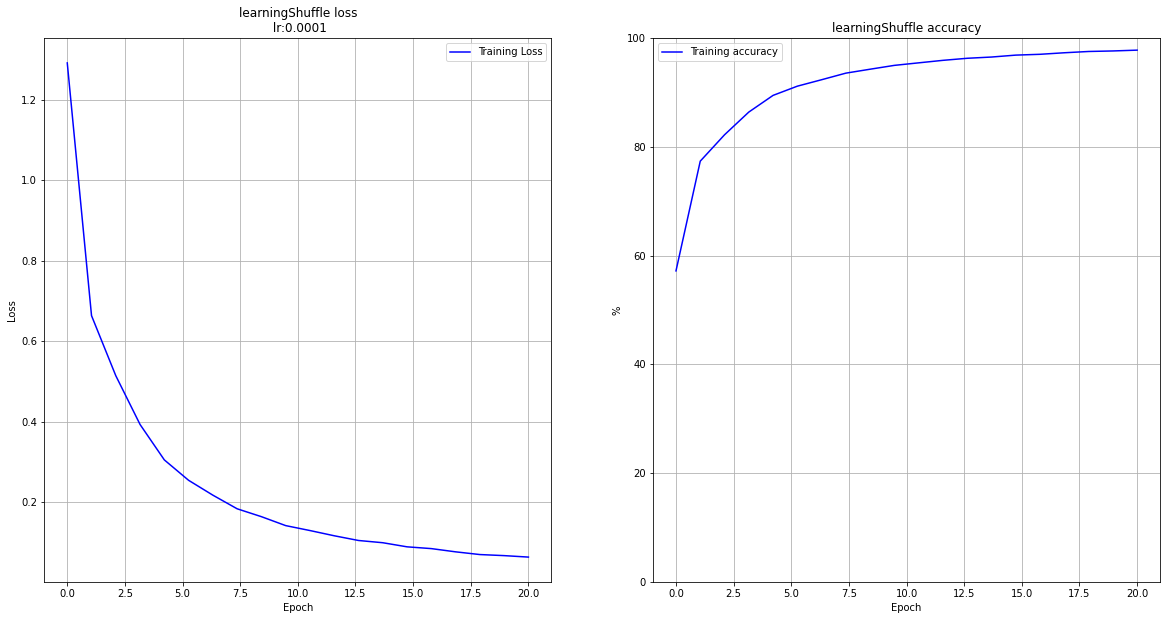

In [62]:
# Plot loss and acc
# Loss plot
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize = (20,10))
x = np.linspace(0, num_epochs, len(train_loss_history))
ax1.plot(x, train_loss_history, c = "b")
ax1.set_title(f'{model_name} loss\n lr:{lr}')
ax1.legend(["Training Loss"])
ax1.set_ylabel("Loss")
ax1.set_xlabel("Epoch")
ax1.grid(True)

# Acc plot
x = np.linspace(0, num_epochs, len(train_acc_history))
ax2.plot(x, train_acc_history, c = "b")
ax2.set_ylim([0, 100])
ax2.set_title(f'{model_name} accuracy')
ax2.legend(["Training accuracy"])
ax2.set_ylabel("%")
ax2.set_xlabel("Epoch")
ax2.grid(True)

fig.savefig(f'figures/{model_name}.pdf')

# Transfer learning
## Now we need to do transfer learning and change to output fc layer
We will also need to freeze the upper layers. 

In [63]:
shuffleNet = torchvision.models.resnet18(pretrained=False).to(device)
shuffleNet_fc_in = shuffleNet.fc.in_features
shuffleNet.fc = nn.Linear(shuffleNet_fc_in, shuffle_out_classes).to(device)

# Load the saved model
if os.path.isfile(save_path):
    shuffleNet.load_state_dict(torch.load(save_path))
    print("Model loaded")
else:
    # Raise error if it does not exist
    raise ValueError("Model does not exist!")

# Turn off learning 
for param in shuffleNet.parameters():
    param.requires_grad = False

# Swap bottom layers
#shuffleNet.layer3 = torchvision.models.resnet18(pretrained=False).layer3.to(device)
shuffleNet.layer4 = torchvision.models.resnet18(pretrained=False).layer4.to(device)
shuffleNet.fc = nn.Linear(shuffleNet_fc_in, 10).to(device)

# Pass only the unfreezed layer to the optimiser
lr = 1e-4
optimizer2 = torch.optim.Adam(shuffleNet.parameters(), lr)
loss_func2 = nn.CrossEntropyLoss()

shuffleNet = shuffleNet.to(device)

# Save model 
shuffleNet_name = 'shuffleNet'
#Create Save Path from save_dir and model_name, we will save and load our checkpoint here
shuffleNet_save_path = os.path.join(save_dir, shuffleNet_name + ".pt")

num_epochs = 30

Model loaded


### Train the semi-supervised model


In [64]:
best_acc, best_epoch, train_acc_history, train_loss_history, val_acc_history, val_loss_history = train_model(shuffleNet, [train_loader, valid_loader], loss_func2, optimizer2, shuffleNet_save_path, num_epochs=num_epochs)
test_acc, _, _, _, _, test_loss_history = train_model(shuffleNet, [test_loader], loss_func2, optimizer2, shuffleNet_save_path, num_epochs=1, is_test = True)

Epoch: [ 1/30] [ phase: train | Loss: 2.2080 | Acc: 19.60% ] [ phase: val | Loss: 2.0120 | Acc: 27.71% ]
Epoch: [ 2/30] [ phase: train | Loss: 1.7659 | Acc: 41.80% ] [ phase: val | Loss: 1.7929 | Acc: 33.78% ]
Epoch: [ 3/30] [ phase: train | Loss: 1.5251 | Acc: 47.20% ] [ phase: val | Loss: 1.6397 | Acc: 39.69% ]
Epoch: [ 4/30] [ phase: train | Loss: 1.3766 | Acc: 51.20% ] [ phase: val | Loss: 1.5487 | Acc: 43.38% ]
Epoch: [ 5/30] [ phase: train | Loss: 1.2396 | Acc: 60.20% ] [ phase: val | Loss: 1.5149 | Acc: 44.76% ]
Epoch: [ 6/30] [ phase: train | Loss: 1.1257 | Acc: 63.80% ] [ phase: val | Loss: 1.4800 | Acc: 45.42% ]
Epoch: [ 7/30] [ phase: train | Loss: 1.0065 | Acc: 69.60% ] [ phase: val | Loss: 1.4837 | Acc: 46.16% ]
Epoch: [ 8/30] [ phase: train | Loss: 0.9524 | Acc: 68.40% ] [ phase: val | Loss: 1.4827 | Acc: 46.89% ]
Epoch: [ 9/30] [ phase: train | Loss: 0.8852 | Acc: 73.80% ] [ phase: val | Loss: 1.4772 | Acc: 46.89% ]
Epoch: [10/30] [ phase: train | Loss: 0.8195 | Acc: 76.

### Visualize the output data

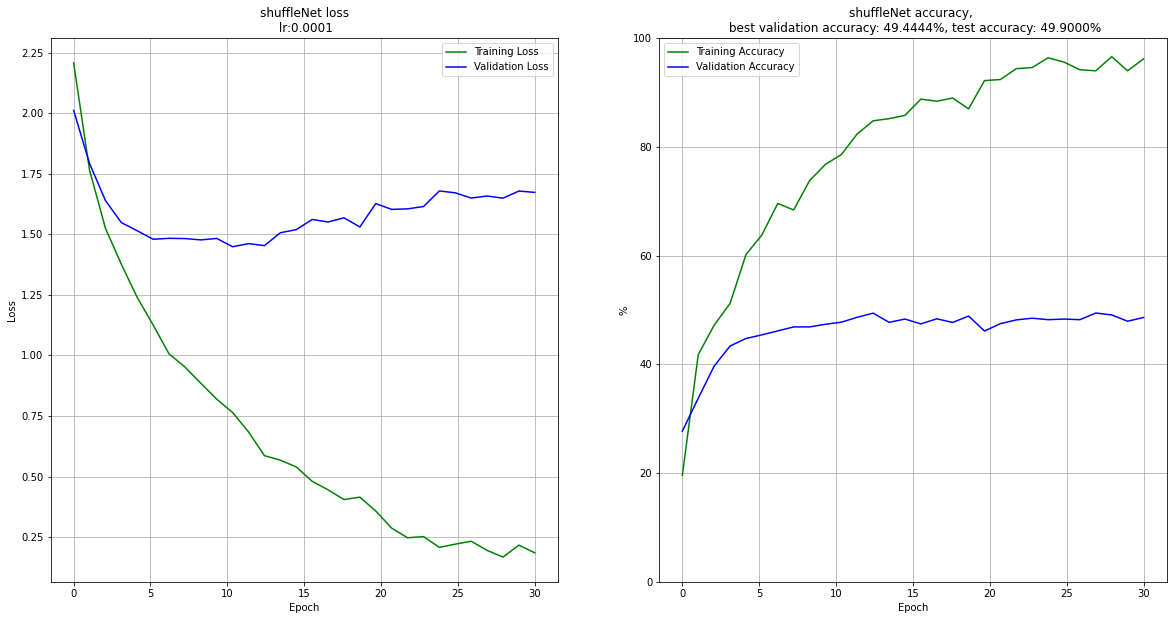

In [65]:
# Plot loss and acc
# Loss plot
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize = (20,10))
x = np.linspace(0, num_epochs, len(train_loss_history))
ax1.plot(x, train_loss_history, c = "g")
x = np.linspace(0, num_epochs, len(val_loss_history))
ax1.plot(x, val_loss_history, c = "b")
ax1.set_title(f'{shuffleNet_name} loss\n lr:{lr}')
ax1.legend(["Training Loss", "Validation Loss"])
ax1.set_ylabel("Loss")
ax1.set_xlabel("Epoch")
ax1.grid(True)

# Acc plot
x = np.linspace(0, num_epochs, len(train_acc_history))
ax2.plot(x, train_acc_history, c = "g")
x = np.linspace(0, num_epochs, len(val_acc_history))
ax2.plot(x, val_acc_history, c = "b")
ax2.set_ylim([0, 100])
ax2.set_title(f'{shuffleNet_name} accuracy, \n best validation accuracy: {best_acc:.04f}%, test accuracy: {test_acc:.04f}%')
ax2.legend(["Training Accuracy", "Validation Accuracy"])
ax2.set_ylabel("%")
ax2.set_xlabel("Epoch")
ax2.grid(True)

fig.savefig(f'figures/{shuffleNet_name}_layer4.pdf')